# Phase 4: Exploratory Data Analysis using SQL

**Executive Summary:** 
This notebook leverages the power of SQL to perform complex aggregations and multi-dimensional analysis. By querying the dataset within a relational environment, we identify high-level trends regarding launch site performance, payload trends, and booster reliability that are not immediately visible in raw tables.

**Objectives:**
- Load the cleaned dataset into a SQLite database for structured relational querying.
- Calculate success rates across different launch sites and payload categories using SQL aggregations.
- Analyze booster version performance to identify the "learning curve" in SpaceX’s reusability technology.
- Extract specific subsets of data (e.g., successful drone ship landings) to validate business-critical hypotheses.

**Acknowledgments:**
- Original lab structure from IBM Data Science Professional Certificate

## 1) IMPORTING LIBRARIES

In [1]:
# Import libraries
import csv
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load SQL extension for Jupyter
%load_ext sql

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Environment setup complete")

 Environment setup complete


## 2) DATABASE CONNECTION & DATA LOADING

In [2]:
# Create SQLite database connection
con = sqlite3.connect("spacex_launch_data.db")
cur = con.cursor()

# Connect SQL magic to our database
%sql sqlite:///spacex_launch_data.db

print(" Database connection established")

# Load SpaceX dataset
print("Loading SpaceX launch data...")
df = pd.read_csv(
    "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/labs/module_2/data/Spacex.csv"
)

# Initial data exploration
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

# Check for missing values
print(f"\nMissing values:\n{df.isnull().sum()}")

# Data type information
print(f"\nData types:\n{df.dtypes}")

# Load data into SQLite database
df.to_sql("SPACEXTBL", con, if_exists='replace', index=False, method="multi")

# Clean data: Remove rows where Date is null
%sql DROP TABLE IF EXISTS SPACEXTABLE;
%sql CREATE TABLE SPACEXTABLE AS SELECT * FROM SPACEXTBL WHERE Date IS NOT NULL;

print("\n Data loaded and cleaned successfully")

# Verify data load - Using pandas instead of sql magic to avoid prettytable issue
verify_query = "SELECT COUNT(*) as total_records FROM SPACEXTABLE"
total_records = pd.read_sql_query(verify_query, con)
print(f"\nTotal records in database: {total_records['total_records'][0]}")

 Database connection established
Loading SpaceX launch data...

Dataset Shape: (101, 10)
Columns: ['Date', 'Time (UTC)', 'Booster_Version', 'Launch_Site', 'Payload', 'PAYLOAD_MASS__KG_', 'Orbit', 'Customer', 'Mission_Outcome', 'Landing_Outcome']

First few rows:
         Date Time (UTC) Booster_Version  Launch_Site  \
0  2010-06-04   18:45:00  F9 v1.0  B0003  CCAFS LC-40   
1  2010-12-08   15:43:00  F9 v1.0  B0004  CCAFS LC-40   
2  2012-05-22    7:44:00  F9 v1.0  B0005  CCAFS LC-40   
3  2012-10-08    0:35:00  F9 v1.0  B0006  CCAFS LC-40   
4  2013-03-01   15:10:00  F9 v1.0  B0007  CCAFS LC-40   

                                             Payload  PAYLOAD_MASS__KG_  \
0               Dragon Spacecraft Qualification Unit                  0   
1  Dragon demo flight C1, two CubeSats, barrel of...                  0   
2                              Dragon demo flight C2                525   
3                                       SpaceX CRS-1                500   
4                  

## 3) EDA WITH SQL

In [3]:
# Task 1: Identify Unique Launch Sites

print("\n[TASK 1] Unique Launch Sites")
print("-" * 40)

query_1 = """
SELECT DISTINCT TRIM("Launch_Site") 
FROM SPACEXTABLE
ORDER BY Launch_Site;
"""

result_1 = pd.read_sql_query(query_1, con)
print(f"Number of unique launch sites: {len(result_1)}")
print(result_1)


[TASK 1] Unique Launch Sites
----------------------------------------
Number of unique launch sites: 4
  TRIM("Launch_Site")
0         CCAFS LC-40
1        CCAFS SLC-40
2          KSC LC-39A
3         VAFB SLC-4E


In [4]:
# Task 2: Launch Sites Beginning with 'CCA'

print("\n[TASK 2] Launches from sites beginning with 'CCA'")
print("-" * 40)

query_2 = """
SELECT * 
FROM SPACEXTABLE
WHERE Launch_Site LIKE 'CCA%'
LIMIT 5;
"""

result_2 = pd.read_sql_query(query_2, con)
print(result_2)


[TASK 2] Launches from sites beginning with 'CCA'
----------------------------------------
         Date Time (UTC) Booster_Version  Launch_Site  \
0  2010-06-04   18:45:00  F9 v1.0  B0003  CCAFS LC-40   
1  2010-12-08   15:43:00  F9 v1.0  B0004  CCAFS LC-40   
2  2012-05-22    7:44:00  F9 v1.0  B0005  CCAFS LC-40   
3  2012-10-08    0:35:00  F9 v1.0  B0006  CCAFS LC-40   
4  2013-03-01   15:10:00  F9 v1.0  B0007  CCAFS LC-40   

                                             Payload  PAYLOAD_MASS__KG_  \
0               Dragon Spacecraft Qualification Unit                  0   
1  Dragon demo flight C1, two CubeSats, barrel of...                  0   
2                              Dragon demo flight C2                525   
3                                       SpaceX CRS-1                500   
4                                       SpaceX CRS-2                677   

       Orbit         Customer Mission_Outcome      Landing_Outcome  
0        LEO           SpaceX         Success

In [5]:
# Task 3: Total Payload Mass for NASA (CRS) Missions

print("\n[TASK 3] Total Payload Mass - NASA CRS Missions")
print("-" * 40)

query_3 = """
SELECT SUM(PAYLOAD_MASS__KG_) AS Total_Payload_Mass_KG
FROM SPACEXTABLE
WHERE Customer = 'NASA (CRS)';
"""

result_3 = pd.read_sql_query(query_3, con)
print(f"Total payload mass for NASA CRS missions: {result_3['Total_Payload_Mass_KG'][0]:,.0f} kg")




[TASK 3] Total Payload Mass - NASA CRS Missions
----------------------------------------
Total payload mass for NASA CRS missions: 45,596 kg


In [6]:
# Task 4: Average Payload Mass for Booster Version F9 v1.1

print("\n[TASK 4] Average Payload Mass - F9 v1.1")
print("-" * 40)

query_4 = """
SELECT AVG(PAYLOAD_MASS__KG_) AS Avg_Payload_Mass_KG
FROM SPACEXTABLE
WHERE Booster_Version = 'F9 v1.1';
"""

result_4 = pd.read_sql_query(query_4, con)
print(f"Average payload mass for F9 v1.1: {result_4['Avg_Payload_Mass_KG'][0]:,.2f} kg")


[TASK 4] Average Payload Mass - F9 v1.1
----------------------------------------
Average payload mass for F9 v1.1: 2,928.40 kg


In [7]:
# Task 5: First Successful Ground Pad Landing

print("\n[TASK 5] First Successful Ground Pad Landing")
print("-" * 40)

query_5 = """
SELECT MIN(Date) AS First_Success_Date
FROM SPACEXTABLE
WHERE Landing_Outcome = 'Success (ground pad)';
"""

result_5 = pd.read_sql_query(query_5, con)
print(f"First successful ground pad landing: {result_5['First_Success_Date'][0]}")


[TASK 5] First Successful Ground Pad Landing
----------------------------------------
First successful ground pad landing: 2015-12-22


In [8]:
# Task 6: Successful Drone Ship Landings (Payload: 4000-6000 kg)

print("\n[TASK 6] Successful Drone Ship Landings (4000-6000 kg payload)")
print("-" * 40)

query_6 = """
SELECT Booster_Version, PAYLOAD_MASS__KG_, Landing_Outcome
FROM SPACEXTABLE
WHERE Landing_Outcome = 'Success (drone ship)'
  AND PAYLOAD_MASS__KG_ > 4000 
  AND PAYLOAD_MASS__KG_ < 6000
ORDER BY PAYLOAD_MASS__KG_ DESC;
"""

result_6 = pd.read_sql_query(query_6, con)
print(f"Number of successful drone ship landings in range: {len(result_6)}")
print(result_6)


[TASK 6] Successful Drone Ship Landings (4000-6000 kg payload)
----------------------------------------
Number of successful drone ship landings in range: 4
  Booster_Version  PAYLOAD_MASS__KG_       Landing_Outcome
0  F9 FT  B1021.2               5300  Success (drone ship)
1  F9 FT  B1031.2               5200  Success (drone ship)
2     F9 FT B1022               4696  Success (drone ship)
3     F9 FT B1026               4600  Success (drone ship)



[TASK 7] Mission Outcome Summary
----------------------------------------
                    Mission_Outcome  Count
0                           Success     98
1  Success (payload status unclear)      1
2                          Success       1
3               Failure (in flight)      1


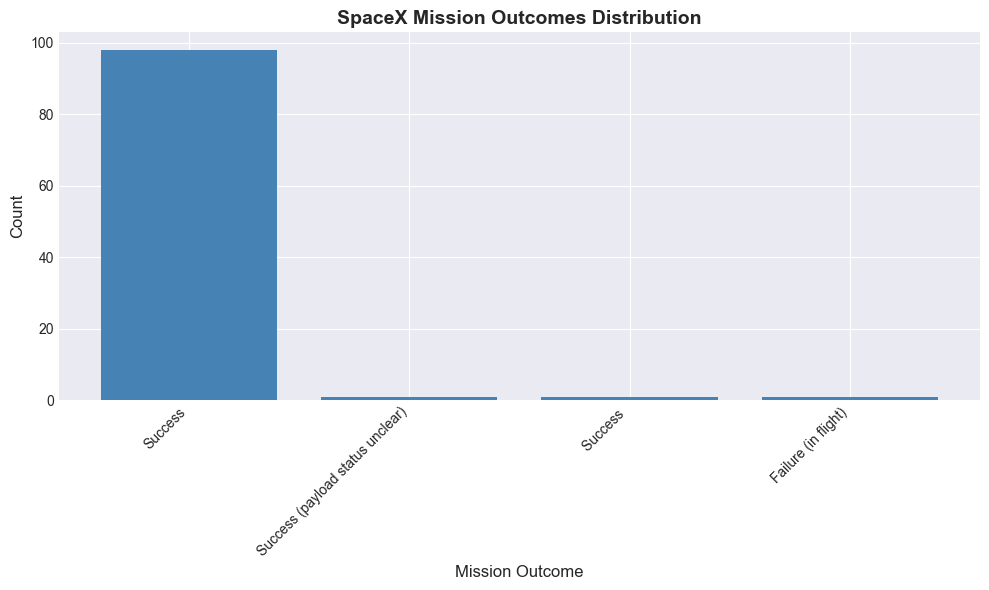

In [9]:
# Task 7: Mission Outcome Summary

print("\n[TASK 7] Mission Outcome Summary")
print("-" * 40)

query_7 = """
SELECT 
    Mission_Outcome,
    COUNT(*) AS Count
FROM SPACEXTABLE
GROUP BY Mission_Outcome
ORDER BY Count DESC;
"""

result_7 = pd.read_sql_query(query_7, con)
print(result_7)

# Visualize mission outcomes
plt.figure(figsize=(10, 6))
plt.bar(result_7['Mission_Outcome'], result_7['Count'], color='steelblue')
plt.xlabel('Mission Outcome', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('SpaceX Mission Outcomes Distribution', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [10]:
# [DATA CLEANING STEP] Standardizing Landing Outcomes
# This query handles the hidden '\n' characters found during initial audit
query_cleaned_landings = """
SELECT 
    TRIM(Landing_Outcome) AS Cleaned_Outcome, 
    COUNT(*) as Total 
FROM SPACEXTBL 
GROUP BY Cleaned_Outcome
ORDER BY Total DESC;
"""

result_cleaned = pd.read_sql_query(query_cleaned_landings, con)
print("Cleaned Landing Outcomes Table:")
print(result_cleaned)

Cleaned Landing Outcomes Table:
          Cleaned_Outcome  Total
0                 Success     38
1              No attempt     22
2    Success (drone ship)     14
3    Success (ground pad)      9
4    Failure (drone ship)      5
5      Controlled (ocean)      5
6                 Failure      3
7    Uncontrolled (ocean)      2
8     Failure (parachute)      2
9  Precluded (drone ship)      1


In [11]:
# Task 8: Booster Versions with Maximum Payload

print("\n[TASK 8] Booster Versions Carrying Maximum Payload")
print("-" * 40)

query_8 = """
SELECT DISTINCT Booster_Version, PAYLOAD_MASS__KG_
FROM SPACEXTABLE
WHERE PAYLOAD_MASS__KG_ = (
    SELECT MAX(PAYLOAD_MASS__KG_) 
    FROM SPACEXTABLE
)
ORDER BY Booster_Version;
"""

result_8 = pd.read_sql_query(query_8, con)
print(f"Maximum payload mass: {result_8['PAYLOAD_MASS__KG_'][0]:,.0f} kg")
print(result_8)


[TASK 8] Booster Versions Carrying Maximum Payload
----------------------------------------
Maximum payload mass: 15,600 kg
   Booster_Version  PAYLOAD_MASS__KG_
0    F9 B5 B1048.4              15600
1    F9 B5 B1048.5              15600
2    F9 B5 B1049.4              15600
3    F9 B5 B1049.5              15600
4   F9 B5 B1049.7               15600
5    F9 B5 B1051.3              15600
6    F9 B5 B1051.4              15600
7    F9 B5 B1051.6              15600
8    F9 B5 B1056.4              15600
9   F9 B5 B1058.3               15600
10  F9 B5 B1060.2               15600
11   F9 B5 B1060.3              15600


In [12]:
# Task 9: Failed Drone Ship Landings in 2015

print("\n[TASK 9] Failed Drone Ship Landings - 2015")
print("-" * 40)

query_9 = """
SELECT 
    substr(Date, 6, 2) AS Month,
    Landing_Outcome,
    Booster_Version,
    Launch_Site
FROM SPACEXTABLE
WHERE Landing_Outcome LIKE '%Failure (drone ship)%'
  AND substr(Date, 1, 4) = '2015'
ORDER BY Date;
"""

result_9 = pd.read_sql_query(query_9, con)
print(f"Number of drone ship failures in 2015: {len(result_9)}")
print(result_9)


[TASK 9] Failed Drone Ship Landings - 2015
----------------------------------------
Number of drone ship failures in 2015: 2
  Month       Landing_Outcome Booster_Version  Launch_Site
0    01  Failure (drone ship)   F9 v1.1 B1012  CCAFS LC-40
1    04  Failure (drone ship)   F9 v1.1 B1015  CCAFS LC-40



[TASK 10] Landing Outcome Rankings (June 2010 - March 2017)
----------------------------------------
          Landing_Outcome  Outcome_Count
0              No attempt             10
1    Success (drone ship)              5
2    Failure (drone ship)              5
3    Success (ground pad)              3
4      Controlled (ocean)              3
5    Uncontrolled (ocean)              2
6     Failure (parachute)              2
7  Precluded (drone ship)              1


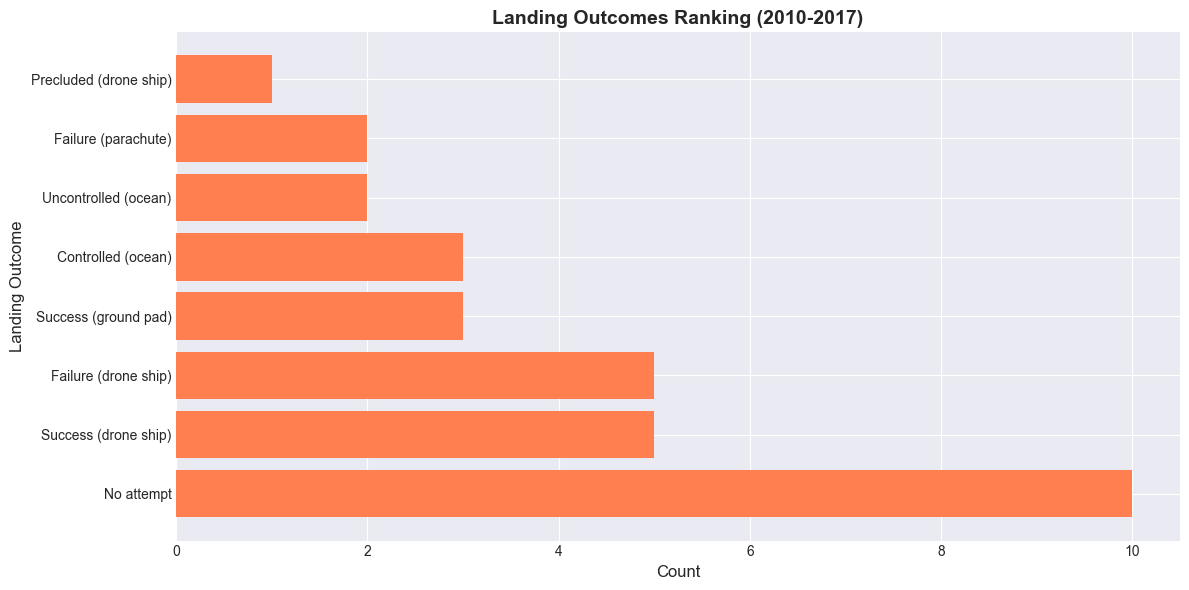

In [13]:
# Task 10: Landing Outcome Rankings (2010-2017)

print("\n[TASK 10] Landing Outcome Rankings (June 2010 - March 2017)")
print("-" * 40)

query_10 = """
SELECT 
    Landing_Outcome,
    COUNT(*) AS Outcome_Count
FROM SPACEXTABLE
WHERE Date BETWEEN '2010-06-04' AND '2017-03-20'
GROUP BY Landing_Outcome
ORDER BY Outcome_Count DESC;
"""

result_10 = pd.read_sql_query(query_10, con)
print(result_10)

# Visualize landing outcomes over time
plt.figure(figsize=(12, 6))
plt.barh(result_10['Landing_Outcome'], result_10['Outcome_Count'], color='coral')
plt.xlabel('Count', fontsize=12)
plt.ylabel('Landing Outcome', fontsize=12)
plt.title('Landing Outcomes Ranking (2010-2017)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4) ADVANCED ANALYSIS & INSIGHTS


[INSIGHT 1] Success Rate by Launch Site
----------------------------------------
    Launch_Site  Total_Launches  Successful_Landings  Success_Rate_Percent
0    KSC LC-39A              25                   20                 80.00
1  CCAFS SLC-40              34                   25                 73.53
2   VAFB SLC-4E              16                   10                 62.50
3   CCAFS LC-40              26                    6                 23.08


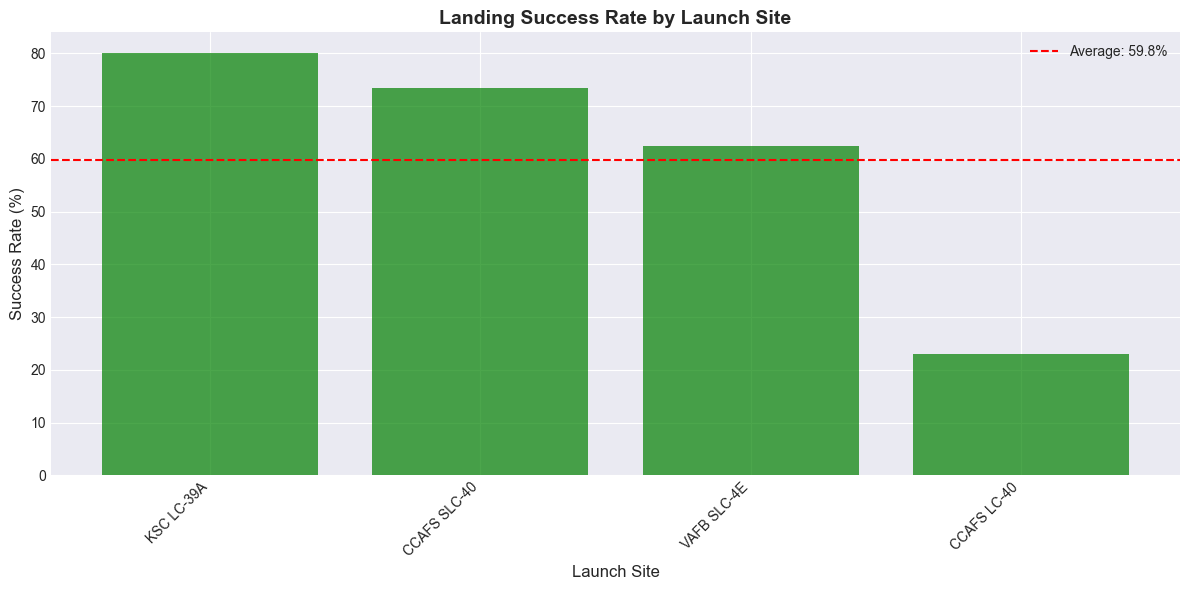

In [14]:
# Success rate by launch site
print("\n[INSIGHT 1] Success Rate by Launch Site")
print("-" * 40)

query_success_rate = """
SELECT 
    Launch_Site,
    COUNT(*) AS Total_Launches,
    SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) AS Successful_Landings,
    ROUND(100.0 * SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) / COUNT(*), 2) AS Success_Rate_Percent
FROM SPACEXTABLE
GROUP BY Launch_Site
ORDER BY Success_Rate_Percent DESC;
"""

success_rate = pd.read_sql_query(query_success_rate, con)
print(success_rate)

# Visualize success rate by launch site
plt.figure(figsize=(12, 6))
plt.bar(success_rate['Launch_Site'], success_rate['Success_Rate_Percent'], color='green', alpha=0.7)
plt.xlabel('Launch Site', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Landing Success Rate by Launch Site', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=success_rate['Success_Rate_Percent'].mean(), color='r', linestyle='--', 
            label=f'Average: {success_rate["Success_Rate_Percent"].mean():.1f}%')
plt.legend()
plt.tight_layout()
plt.show()


[INSIGHT 2] Success Rate by Booster Version
----------------------------------------
  Booster_Version  Total_Launches  Successful_Landings  Success_Rate_Percent
0         F9 v1.1               5                    0                   0.0


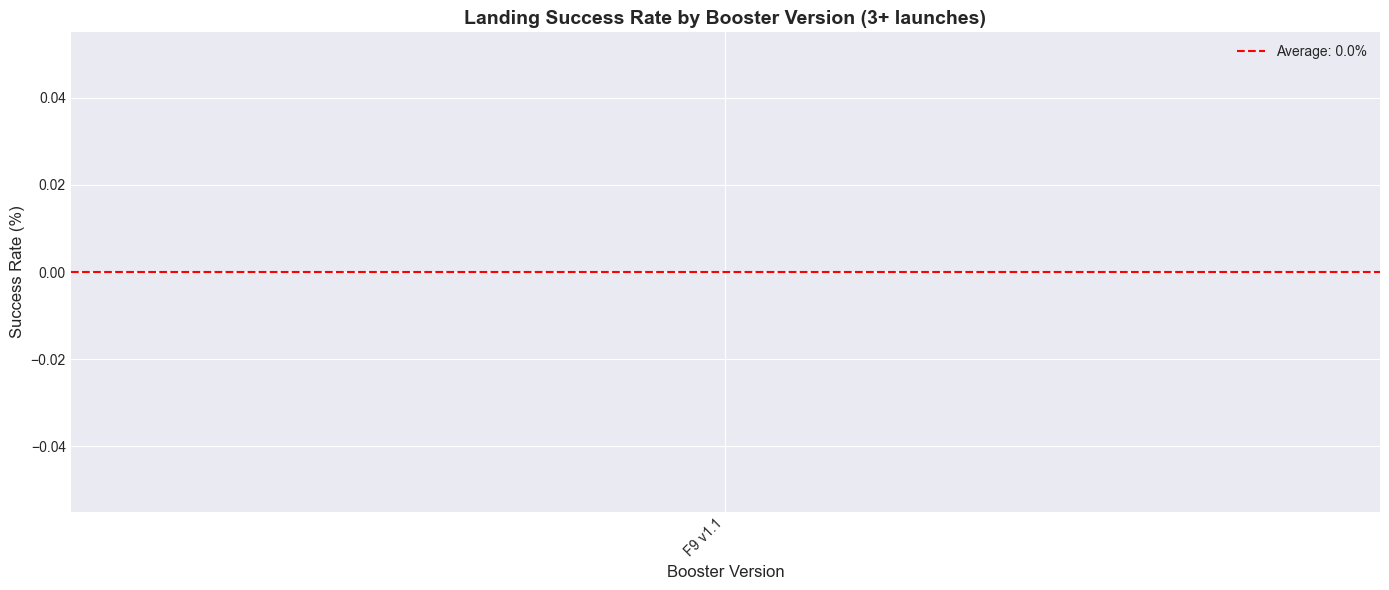

In [15]:
# Success rate by booster version
print("\n[INSIGHT 2] Success Rate by Booster Version")
print("-" * 40)

query_booster_success = """
SELECT 
    Booster_Version,
    COUNT(*) AS Total_Launches,
    SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) AS Successful_Landings,
    ROUND(100.0 * SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) / COUNT(*), 2) AS Success_Rate_Percent
FROM SPACEXTABLE
GROUP BY Booster_Version
HAVING COUNT(*) >= 3
ORDER BY Success_Rate_Percent DESC;
"""

booster_success = pd.read_sql_query(query_booster_success, con)
print(booster_success)

# Visualize success rate by booster version
plt.figure(figsize=(14, 6))
plt.bar(booster_success['Booster_Version'], booster_success['Success_Rate_Percent'], 
        color='teal', alpha=0.7)
plt.xlabel('Booster Version', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.title('Landing Success Rate by Booster Version (3+ launches)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=booster_success['Success_Rate_Percent'].mean(), color='r', linestyle='--',
            label=f'Average: {booster_success["Success_Rate_Percent"].mean():.1f}%')
plt.legend()
plt.tight_layout()
plt.show()


[INSIGHT 3] Payload Mass Trends Over Time
----------------------------------------


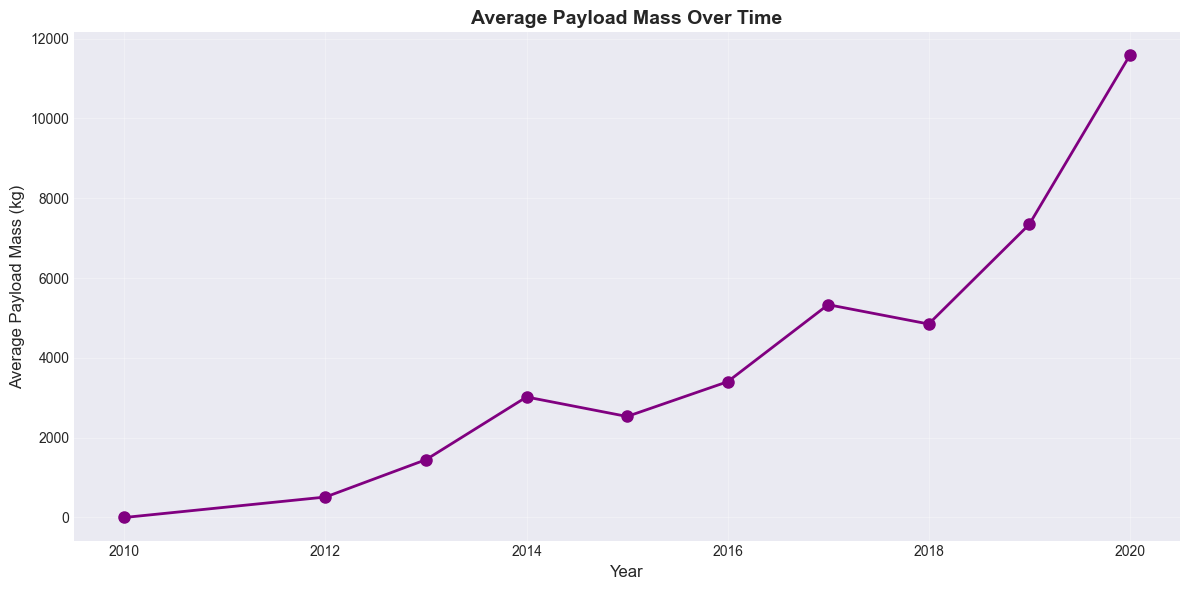

In [16]:
# Payload mass trends over time
print("\n[INSIGHT 3] Payload Mass Trends Over Time")
print("-" * 40)

query_payload_trends = """
SELECT 
    Date,
    PAYLOAD_MASS__KG_,
    Booster_Version,
    Landing_Outcome
FROM SPACEXTABLE
ORDER BY Date;
"""

payload_trends = pd.read_sql_query(query_payload_trends, con)
payload_trends['Date'] = pd.to_datetime(payload_trends['Date'])
payload_trends['Year'] = payload_trends['Date'].dt.year

# Calculate yearly average payload
yearly_avg = payload_trends.groupby('Year')['PAYLOAD_MASS__KG_'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['Year'], yearly_avg['PAYLOAD_MASS__KG_'], marker='o', 
         linewidth=2, markersize=8, color='purple')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Payload Mass (kg)', fontsize=12)
plt.title('Average Payload Mass Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


[INSIGHT 4] Landing Success Evolution Over Time
----------------------------------------
   Year  Total_Launches  Successful_Landings  Success_Rate
0  2010               2                    0          0.00
1  2012               2                    0          0.00
2  2013               3                    0          0.00
3  2014               6                    0          0.00
4  2015               7                    1         14.29
5  2016               8                    5         62.50
6  2017              18                   14         77.78
7  2018              20                   10         50.00
8  2019              11                   10         90.91
9  2020              24                   21         87.50


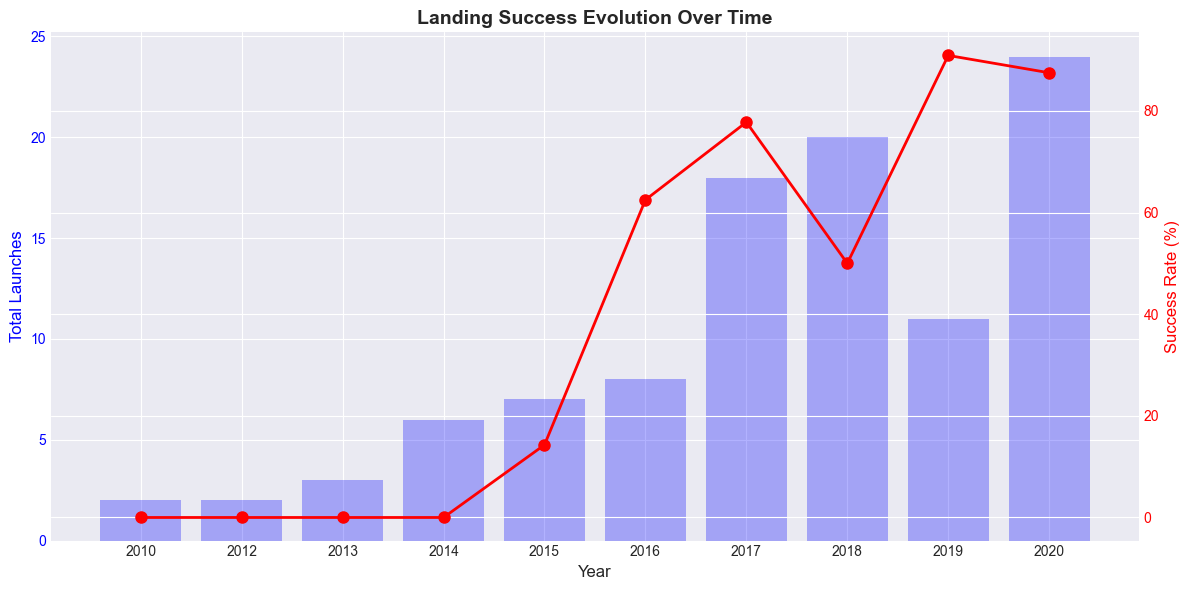

In [17]:
# Landing outcome evolution
print("\n[INSIGHT 4] Landing Success Evolution Over Time")
print("-" * 40)

query_evolution = """
SELECT 
    substr(Date, 1, 4) AS Year,
    COUNT(*) AS Total_Launches,
    SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) AS Successful_Landings,
    ROUND(100.0 * SUM(CASE WHEN Landing_Outcome LIKE '%Success%' THEN 1 ELSE 0 END) / COUNT(*), 2) AS Success_Rate
FROM SPACEXTABLE
GROUP BY Year
ORDER BY Year;
"""

evolution = pd.read_sql_query(query_evolution, con)
print(evolution)

# Visualize evolution
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(evolution['Year'], evolution['Total_Launches'], alpha=0.3, color='blue', label='Total Launches')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Total Launches', fontsize=12, color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(evolution['Year'], evolution['Success_Rate'], color='red', marker='o', 
         linewidth=2, markersize=8, label='Success Rate (%)')
ax2.set_ylabel('Success Rate (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Landing Success Evolution Over Time', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.show()

## 5) KEY FINDINGS & CONCLUSIONS

In [18]:
# Calculate summary statistics
total_launches = len(df)
successful_landings = len(df[df['Landing_Outcome'].str.contains('Success', na=False)])
success_rate = (successful_landings / total_launches) * 100

print(f"""
EXECUTIVE SUMMARY:
------------------
1. DATASET OVERVIEW:
   - Total Launches Analyzed: {total_launches}
   - Successful Landings: {successful_landings}
   - Overall Success Rate: {success_rate:.2f}%

2. LAUNCH SITES: 
   - SpaceX operates from {len(result_1)} distinct launch sites
   - Success rates vary by location, with some sites showing significantly 
     better performance than others

3. PAYLOAD CAPACITY: 
   - Maximum payload carried: {result_8['PAYLOAD_MASS__KG_'][0]:,.0f} kg
   - Average payload for F9 v1.1: {result_4['Avg_Payload_Mass_KG'][0]:,.2f} kg
   - Payload capacity has generally increased over time

4. LANDING SUCCESS EVOLUTION:
   - First successful ground pad landing: {result_5['First_Success_Date'][0]}
   - Success rates have improved significantly over the years
   - Newer booster versions demonstrate higher reliability

5. COST IMPLICATIONS:
   - Understanding landing success is crucial for predicting launch costs
   - First-stage reusability provides substantial cost savings ($62M vs $165M+)
   - Higher success rates translate to lower operational costs

6. TECHNICAL PROGRESS:
   - Newer booster versions show improved success rates
   - Demonstrates SpaceX's iterative improvement methodology
   - Both ground pad and drone ship landings have become more reliable

BUSINESS RECOMMENDATIONS:
-------------------------
- Launches from high-success-rate sites should be prioritized
- Newer booster versions offer better reliability for cost-sensitive missions
- Payload optimization strategies can be informed by historical success patterns
""")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

# Close database connection
con.close()
print("\nDatabase connection closed")


EXECUTIVE SUMMARY:
------------------
1. DATASET OVERVIEW:
   - Total Launches Analyzed: 101
   - Successful Landings: 61
   - Overall Success Rate: 60.40%

2. LAUNCH SITES: 
   - SpaceX operates from 4 distinct launch sites
   - Success rates vary by location, with some sites showing significantly 
     better performance than others

3. PAYLOAD CAPACITY: 
   - Maximum payload carried: 15,600 kg
   - Average payload for F9 v1.1: 2,928.40 kg
   - Payload capacity has generally increased over time

4. LANDING SUCCESS EVOLUTION:
   - First successful ground pad landing: 2015-12-22
   - Success rates have improved significantly over the years
   - Newer booster versions demonstrate higher reliability

5. COST IMPLICATIONS:
   - Understanding landing success is crucial for predicting launch costs
   - First-stage reusability provides substantial cost savings ($62M vs $165M+)
   - Higher success rates translate to lower operational costs

6. TECHNICAL PROGRESS:
   - Newer booster versions 